# Project members

**Sali Raffaele**:
- raffaele.sali@studio.unibo.it
- 000

**Zanotti Niccolò**:
- niccolo.zanotti@studio.unibo.it
- 000

**Zocco Ramazzo Marco**:
- marco.zoccoramazzo@studio.unibo.it
- 000


# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [ ]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 25.58 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision.transforms import v2
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [ ]:
train_dataset1 = OxfordPetDataset(split="train")
print(len(train_dataset1))
img, label = train_dataset1[0]
print(img.size, label)

3669
(300, 225) 0


In [ ]:
def breed_from_name(name):
    return "_".join(name.split("_")[:-1])

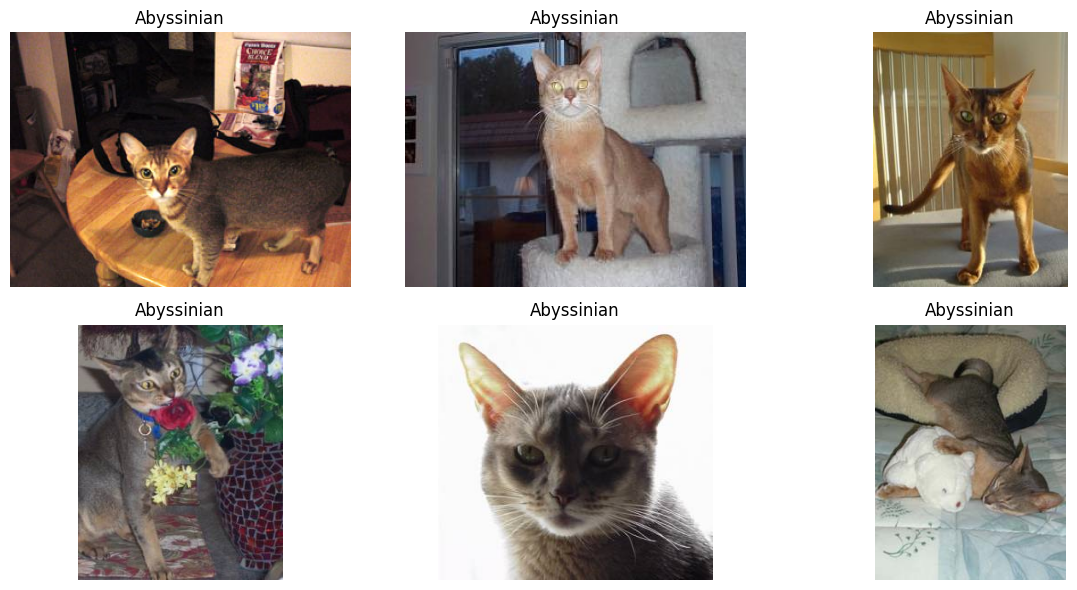

In [ ]:
# Images if we don't apply transformations
plt.figure(figsize=(12, 6))
for i in range(6):
    img, _ = train_dataset1[i]
    name = train_dataset1.names[i]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(breed_from_name(name))
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Images if we apply transformations
import torchvision.transforms as T

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = OxfordPetDataset(split="train", transform=train_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_transform)
validation_dataset = OxfordPetDataset(split="val", transform=val_transform)
print("Number of samples - train:", len(train_dataset))
print("Number of classes - train:", train_dataset.get_num_classes())
print("Number of samples - test:", len(test_dataset))
print("Number of classes - test:", test_dataset.get_num_classes())
print("Number of samples - validation:", len(validation_dataset))
print("Number of classes - validation:", validation_dataset.get_num_classes())

Number of samples - train: 3669
Number of classes - train: 37
Number of samples - test: 1846
Number of classes - test: 37
Number of samples - validation: 1834
Number of classes - validation: 37


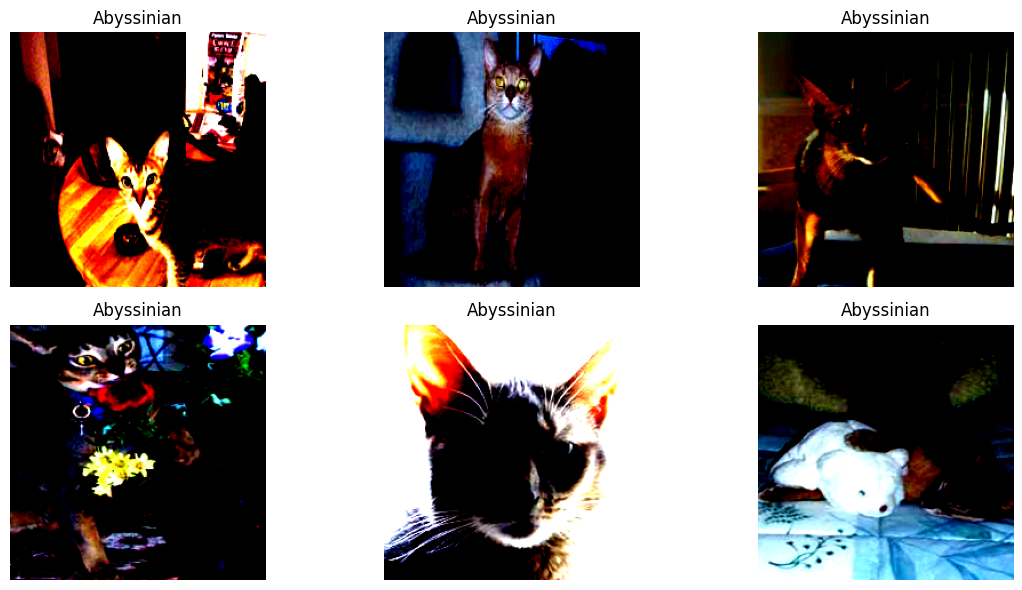

In [ ]:
def show_samples(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img, _ = dataset[i]
        names = dataset.names[i]
        # label = dataset.labels[i]
        img = img.permute(1, 2, 0)

        plt.subplot(2, n//2, i + 1)
        plt.imshow(img)
        plt.title(f"{breed_from_name(names)}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    validation_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
print(images.min(), images.max())

torch.Size([32, 3, 224, 224])
torch.Size([32])
tensor(-2.1179) tensor(2.6400)


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

In [ ]:
def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)
    return (preds == labels).sum()

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            total_correct += accuracy(outputs, labels)
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct.float() / total_samples

    return avg_loss, avg_acc.item()

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection adjustment if shape changes
        self.skip = None
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.skip is not None:
            identity = self.skip(identity)

        out += identity
        return F.relu(out)


# Network Improving

Added:
- Augmented data
- MixUp for higher augmentation
<br>

- Stem layers
- Residual blocks
- Batch Normalization layer
- Pooling layer (Adaptive AvgPooling)

<br>

- Label smoothing
- Dropout
- Early Stopping
- Learning rate scheduler (OneCycle)
- Warmup

In [ ]:
class ImprovedNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Stem layers
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Residual blocks
        self.stage1 = self._make_stage(64, 64, num_blocks=2, stride=1)
        self.stage2 = self._make_stage(64, 128, num_blocks=2, stride=2)
        self.stage3 = self._make_stage(128, 256, num_blocks=2, stride=2)
        self.stage4 = self._make_stage(256, 512, num_blocks=2, stride=2)

        # Classifier
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, n_classes)
        )

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Imp_mdl = ImprovedNet(n_classes=train_dataset.get_num_classes()).to(device)

# Count parameters
total_params = sum(p.numel() for p in Imp_mdl.parameters())
trainable_params = sum(p.numel() for p in Imp_mdl.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,317,349
Trainable parameters: 11,317,349


In [ ]:
num_epochs = 100

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    Imp_mdl.parameters(),
    lr=1e-3,
    weight_decay=1e-2
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos'
)

# MixUp augmentation
mixup = v2.MixUp(alpha=0.2, num_classes=train_dataset.get_num_classes())

print(f"Device: {device}")
print(f"Training samples: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Device: cuda
Training samples: 3669
Batches per epoch: 115


In [ ]:
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    Imp_mdl.train()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Apply MixUp augmentation
        images, labels = mixup(images, labels)

        optimizer.zero_grad()

        outputs = Imp_mdl(images)
        loss = criterion(outputs, labels)

        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(Imp_mdl.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()  # OneCycleLR steps per batch

        total_loss += loss.item() * images.size(0)

        # MixUp returns soft labels, argmax is used for accuracy
        total_correct += (outputs.argmax(dim=1) == labels.argmax(dim=1)).sum()
        total_samples += images.size(0)

    train_loss = total_loss / total_samples
    train_acc = total_correct.float() / total_samples

    val_loss, val_acc = evaluate(Imp_mdl, val_loader, criterion, device)

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc.item())
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(Imp_mdl.state_dict(), "best_improved_net.pth")

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e}"
    )

print(f"\nBest Validation Accuracy: {best_val_acc:.3f}")

Epoch [1/100] | Train Loss: 3.582, Train Acc: 0.050 | Val Loss: 3.511, Val Acc: 0.077 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.510, Train Acc: 0.081 | Val Loss: 3.503, Val Acc: 0.061 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.473, Train Acc: 0.082 | Val Loss: 3.529, Val Acc: 0.065 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.434, Train Acc: 0.097 | Val Loss: 3.602, Val Acc: 0.074 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.402, Train Acc: 0.103 | Val Loss: 3.518, Val Acc: 0.081 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.367, Train Acc: 0.121 | Val Loss: 4.244, Val Acc: 0.054 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 3.328, Train Acc: 0.125 | Val Loss: 3.349, Val Acc: 0.091 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 3.292, Train Acc: 0.146 | Val Loss: 3.225, Val Acc: 0.138 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 3.278, Train Acc: 0.137 | Val Loss: 3.487, Val Acc: 0.082 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 3.212, Train Acc: 0.153 | Val Loss: 3.352, Val Acc: 0.123 | LR

In [ ]:
test_loss, test_acc = evaluate(Imp_mdl, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Test Loss: 1.569
Test Accuracy: 0.692


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.